⚠️ This python code runs on a machine with a single CUDA-capable device (like Colab's Tesla T4)


Setting up 200x200 evaluation grid...

--- Calculating Continuous Membership (basis for comparison) ---


 Processing Continuous Batches: 100%|██████████| 20/20 [00:00<00:00, 2497.43it/s]


Continuous calculation finished in 21.60 seconds.

--- Iterating through Densification Levels ---

Processing for n = 2 prototypes per region...


 Processing Combinatorial Batches: 16it [00:00, 59599.35it/s]


 Combinatorial calculation (n=2) finished in 0.02 seconds.
 MSE vs. Continuous: 0.003735

Processing for n = 3 prototypes per region...


 Processing Combinatorial Batches: 81it [00:00, 368480.07it/s]


 Combinatorial calculation (n=3) finished in 0.09 seconds.
 MSE vs. Continuous: 0.001078

Processing for n = 5 prototypes per region...


 Processing Combinatorial Batches: 625it [00:00, 1328656.87it/s]


 Combinatorial calculation (n=5) finished in 0.69 seconds.
 MSE vs. Continuous: 0.000282

Processing for n = 9 prototypes per region...


 Processing Combinatorial Batches: 6561it [00:00, 176218.62it/s]


 Combinatorial calculation (n=9) finished in 7.15 seconds.
 MSE vs. Continuous: 0.000071

Processing for n = 17 prototypes per region...


 Processing Combinatorial Batches: 83521it [00:00, 167669.78it/s]


 Combinatorial calculation (n=17) finished in 90.32 seconds.
 MSE vs. Continuous: 0.000021

--- Results ---


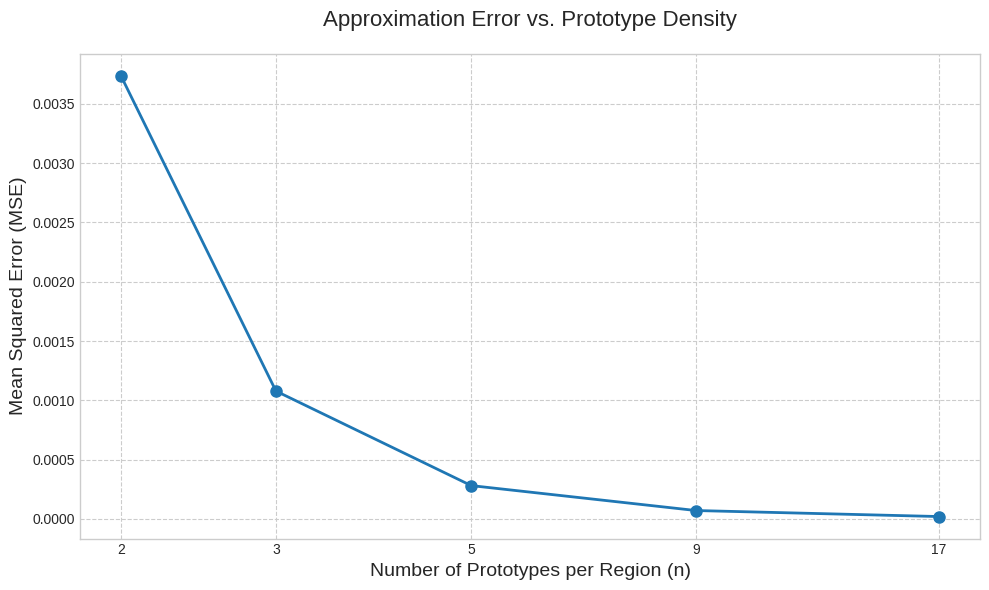

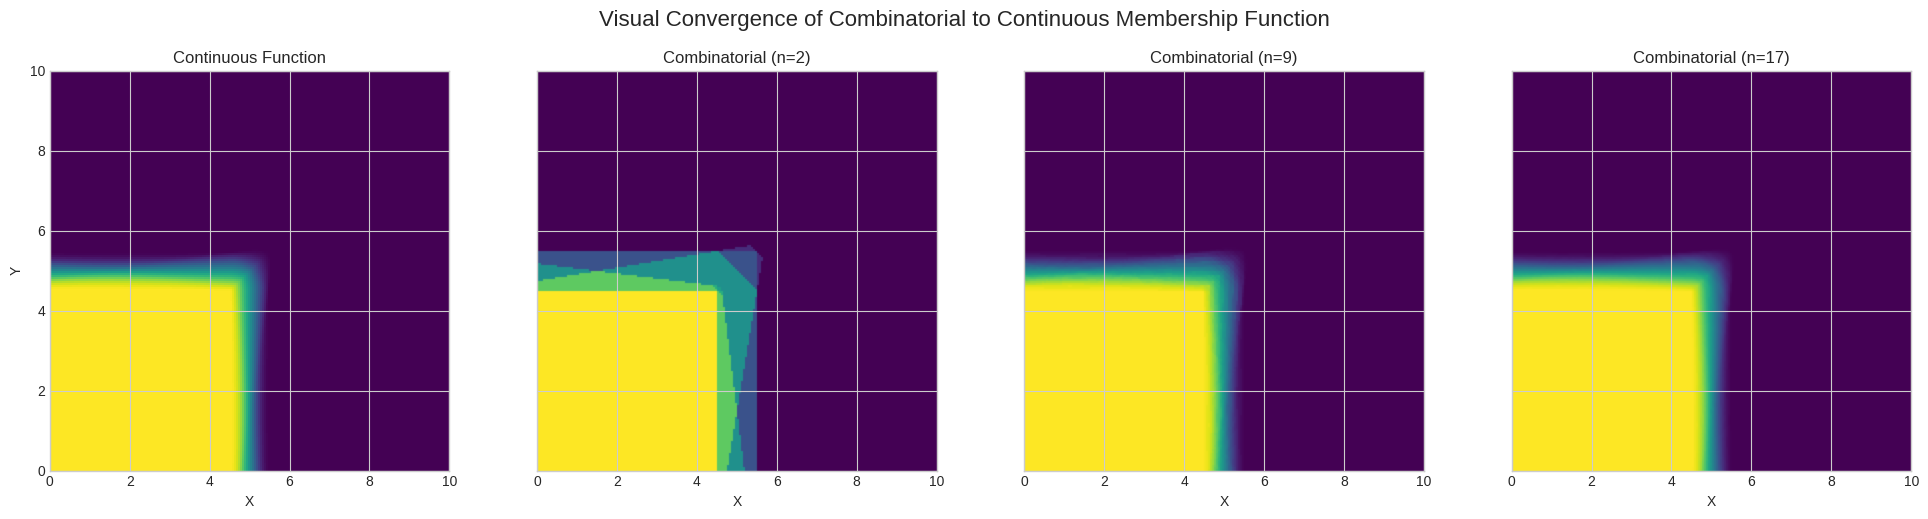


 Check the PNG files for results.


In [2]:
#@title Convergence of combinatorial to continuous membership function

import numpy as np
import cupy as cp
import itertools
import time
import matplotlib.pyplot as plt
from tqdm import tqdm


def define_prototype_segments():
    """Defines the 4 prototypical regions as segments (numpy array).

    This function returns an (4, 2, 2) array where each element is
    [[x_start, y_start], [x_end, y_end]].
    """
    return np.array([
        [[1.0, 1.0], [2.0, 2.0]],  # Region 0
        [[8.0, 1.0], [9.0, 2.0]],  # Region 1
        [[8.0, 8.0], [9.0, 9.0]],  # Region 2
        [[1.0, 8.0], [2.0, 9.0]]   # Region 3
    ], dtype=np.float32)


def densify_segments(segments, num_points):
    """Generates `num_points` prototypes along each segment.

    Returns a list with one (num_points, 2)-shaped array per region.
    """
    densified_prototypes = []
    for seg in segments:
        points = np.linspace(seg[0], seg[1], num_points, dtype=np.float32)
        densified_prototypes.append(points)
    return densified_prototypes


def calculate_continuous_membership_gpu_batched(grid_points_gpu, segments_gpu, target_region, n_samples, batch_size=2048):
    """Calculates the continuous membership function using Monte Carlo on GPU.

    - grid_points_gpu: (n_points, 2) cupy array
    - segments_gpu: (m_regions, 2, 2) cupy array
    - target_region: int (index of region we measure membership for)
    - n_samples: number of Monte Carlo samples
    - batch_size: how many grid points to process at once

    Returns a cupy 1D array of membership degrees for each grid point.
    """
    n_total_points = grid_points_gpu.shape[0]
    m_regions = segments_gpu.shape[0]

    # Random sample positions along each segment: shape (n_samples, m_regions, 1)
    t = cp.random.random((n_samples, m_regions, 1), dtype=cp.float32)

    start_points = segments_gpu[:, 0, :]
    end_points = segments_gpu[:, 1, :]

    # configs: (n_samples, m_regions, 2)
    configs = start_points[None, :, :] + t * (end_points - start_points)[None, :, :]

    # We'll create a results list and concatenate at the end
    results = []

    for i in tqdm(range(0, n_total_points, batch_size), desc=" Processing Continuous Batches"):
        grid_batch_gpu = grid_points_gpu[i:i + batch_size]  # (batch, 2)

        # Expand shapes: grid -> (batch, 1, 1, 2), configs -> (1, n_samples, m_regions, 2)
        grid_expanded = grid_batch_gpu[:, None, None, :]
        configs_expanded = configs[None, :, :, :]

        # Compute squared distances -> (batch, n_samples, m_regions)
        dist_sq = cp.sum((grid_expanded - configs_expanded) ** 2, axis=3)

        # For each (grid point, sample) find closest region index -> (batch, n_samples)
        closest_indices = cp.argmin(dist_sq, axis=2)

        # Count wins where closest region equals target_region across samples -> (batch,)
        wins = cp.sum(closest_indices == int(target_region), axis=1)

        membership_batch = wins.astype(cp.float32) / float(n_samples)
        results.append(membership_batch)

    return cp.concatenate(results)


def calculate_combinatorial_membership_gpu(grid_points_gpu, prototypes, target_region, batch_size=1024):
    """Calculates exact combinatorial membership (all combinations) on GPU.

    This implementation does NOT build the full product list in memory; it iterates
    over the itertools.product generator and processes configurations in batches.

    - prototypes: list of (n_i, 2) numpy arrays (one per region)
    - grid_points_gpu: (n_points, 2) cupy array

    Returns a cupy 1D array of membership degrees for each grid point.
    """
    n_points = grid_points_gpu.shape[0]
    m_regions = len(prototypes)

    total_wins = cp.zeros(n_points, dtype=cp.int32)
    configs_iter = itertools.product(*prototypes)

    processed = 0
    buffer = []

    # We will iterate through the generator in batches to keep memory bounded
    for cfg in tqdm(configs_iter, desc=" Processing Combinatorial Batches"):
        # cfg is a tuple of m_regions arrays with shape (2,)
        buffer.append(cfg)
        if len(buffer) >= batch_size:
            # Convert buffer to a cupy array of shape (batch, m_regions, 2)
            configs_batch_gpu = cp.asarray(buffer, dtype=cp.float32)

            # grid: (n_points, 1, 1, 2) ; configs: (1, batch, m_regions, 2)
            grid_expanded = grid_points_gpu[:, None, None, :]
            configs_expanded = configs_batch_gpu[None, :, :, :]

            dist_sq = cp.sum((grid_expanded - configs_expanded) ** 2, axis=3)
            closest_indices = cp.argmin(dist_sq, axis=2)

            # closest_indices -> (n_points, batch) ; compare to target_region and sum over batch
            wins_in_batch = cp.sum(closest_indices == int(target_region), axis=1)
            total_wins += wins_in_batch

            processed += len(buffer)
            buffer = []

    # Flush remaining buffer
    if buffer:
        configs_batch_gpu = cp.asarray(buffer, dtype=cp.float32)
        grid_expanded = grid_points_gpu[:, None, None, :]
        configs_expanded = configs_batch_gpu[None, :, :, :]
        dist_sq = cp.sum((grid_expanded - configs_expanded) ** 2, axis=3)
        closest_indices = cp.argmin(dist_sq, axis=2)
        wins_in_batch = cp.sum(closest_indices == int(target_region), axis=1)
        total_wins += wins_in_batch
        processed += len(buffer)

    # Total number of configurations processed is the product of densification sizes
    n_configs = 1
    for p in prototypes:
        n_configs *= p.shape[0]

    membership = total_wins.astype(cp.float32) / float(n_configs)
    return membership


def plot_results(continuous_map, combinatorial_maps, errors, densification_levels, grid_res):
    """Plots MSE and membership maps. Picks a middle densification level intelligently
    so that if n=9 exists it will be shown (otherwise the true middle).
    """
    plt.style.use('seaborn-v0_8-whitegrid')

    fig1, ax1 = plt.subplots(figsize=(10, 6))
    num_prototypes = np.array(densification_levels)
    ax1.plot(num_prototypes, errors, 'o-', markersize=8, lw=2)
    ax1.set_xlabel('Number of Prototypes per Region (n)', fontsize=14)
    ax1.set_ylabel('Mean Squared Error (MSE)', fontsize=14)
    ax1.set_title('Approximation Error vs. Prototype Density', fontsize=16, pad=20)
    ax1.set_xscale('log', base=2)
    ax1.set_xticks(num_prototypes)
    ax1.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax1.grid(True, which="both", ls="--")
    fig1.tight_layout()
    plt.savefig("mse_vs_prototypes.png")
    plt.show()

    # Choose indices to display: first, try to show n=9 if present, otherwise show the true middle
    if 9 in densification_levels:
        middle_idx = densification_levels.index(9)
    else:
        middle_idx = len(densification_levels) // 2

    plot_indices = [0, middle_idx, len(densification_levels) - 1]
    num_plots = len(plot_indices) + 1

    fig2, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), sharey=True)
    im = axes[0].imshow(continuous_map, origin='lower', extent=(0, 10, 0, 10), cmap='viridis', vmin=0, vmax=1)
    axes[0].set_title('Continuous Function', fontsize=12)
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')

    for i, idx in enumerate(plot_indices):
        n_val = densification_levels[idx]
        axes[i + 1].imshow(combinatorial_maps[idx], origin='lower', extent=(0, 10, 0, 10), cmap='viridis', vmin=0, vmax=1)
        axes[i + 1].set_title(f'Combinatorial (n={n_val})', fontsize=12)
        axes[i + 1].set_xlabel('X')

    fig2.suptitle('Convergence of combinatorial to continuous membership function', fontsize=16)
    fig2.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig("membership_map_comparison.png")
    plt.show()


if __name__ == "__main__":
    # ASSUMPTION: This script runs on a machine with a single CUDA-capable device
    # (Tesla T4) and the appropriate cupy build installed. We explicitly set the
    # device context to device 0 and DO NOT perform any availability checks.
    cp.cuda.Device(0).use()

    # --- Configuration ---
    GRID_RES = 200
    TARGET_REGION = 0
    MC_SAMPLES = 20000
    DENSIFICATION_LEVELS = [2, 3, 5, 9, 17]

    # --- Setup Grid ---
    print(f"\nSetting up {GRID_RES}x{GRID_RES} evaluation grid...")
    x = np.linspace(0, 10, GRID_RES, dtype=np.float32)
    y = np.linspace(0, 10, GRID_RES, dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    grid_points_np = np.vstack([xx.ravel(), yy.ravel()]).T.astype(np.float32)
    grid_points_gpu = cp.asarray(grid_points_np)

    # --- Calculate the Continuous membership, the ground for comparison ---
    print("\n--- Calculating Continuous Membership (basis for comparison) ---")
    segments_np = define_prototype_segments()
    segments_gpu = cp.asarray(segments_np)

    start_time = time.time()
    continuous_membership_flat = calculate_continuous_membership_gpu_batched(
        grid_points_gpu, segments_gpu, TARGET_REGION, MC_SAMPLES
    )
    cp.cuda.Stream.null.synchronize()
    end_time = time.time()
    print(f"Continuous calculation finished in {end_time - start_time:.2f} seconds.")

    continuous_map = cp.asnumpy(continuous_membership_flat).reshape(GRID_RES, GRID_RES)

    # --- Iteratively Calculate Combinatorial Membership and Error ---
    errors = []
    combinatorial_maps = []

    print("\n--- Iterating through Densification Levels ---")
    for n in DENSIFICATION_LEVELS:
        print(f"\nProcessing for n = {n} prototypes per region...")
        prototypes = densify_segments(segments_np, n)

        start_time = time.time()
        comb_membership_flat = calculate_combinatorial_membership_gpu(
            grid_points_gpu, prototypes, TARGET_REGION
        )
        cp.cuda.Stream.null.synchronize()
        end_time = time.time()

        print(f" Combinatorial calculation (n={n}) finished in {end_time - start_time:.2f} seconds.")

        mse = cp.mean((continuous_membership_flat - comb_membership_flat) ** 2)
        errors.append(cp.asnumpy(mse))
        print(f" MSE vs. Continuous: {errors[-1]:.6f}")

        comb_map = cp.asnumpy(comb_membership_flat).reshape(GRID_RES, GRID_RES)
        combinatorial_maps.append(comb_map)

    # --- Results ---
    print("\n--- Results ---")
    plot_results(continuous_map, combinatorial_maps, errors, DENSIFICATION_LEVELS, GRID_RES)
    print("\n Check the PNG files for results.")

# The following code is based on stochastic sampling. Unlike the previous code, there is no complete and exhaustive enumeration of all Voronoi configurations. As a result, the following Python code is much less costly. For use with more prototypes and/or in higher dimensions, I think that it is preferable to use this sampling method.

In [3]:
#@title Convergence of the combinatorial membership function towards the continuous membership function (more optimized/less costly but a little bit less accurate)

import os
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from scipy.stats import pearsonr

# CUDA Tesla T4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Densification iterations: k = 0..K, n = 2**k + 1
K = 4  # gives n = 2,3,5,9,17
TARGET_IDX = 0  # which concept/region to evaluate
GRID_RES = 80  # grid resolution per axis (GRID_RES x GRID_RES points)
SAMPLE_CONT = 30000  # total Monte Carlo samples for continuous reference (per evaluation overall)
SAMPLE_COMB = 30000  # total sampled configurations for combinatorial approx (per iteration)
BATCH_CONFIG = 3000  # process sampled configurations in batches to save memory
SEED = 42

# Save plots
OUT_DIR = "convergence_results"
os.makedirs(OUT_DIR, exist_ok=True)

# Reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)

# Prototype segments
SEGMENTS = [
    (np.array([1.0, 1.0], dtype=np.float32), np.array([2.0, 2.0], dtype=np.float32)),  # r0 bottom-left
    (np.array([8.0, 1.0], dtype=np.float32), np.array([9.0, 2.0], dtype=np.float32)),  # r1 bottom-right
    (np.array([8.0, 8.0], dtype=np.float32), np.array([9.0, 9.0], dtype=np.float32)),  # r2 top-right
    (np.array([1.0, 8.0], dtype=np.float32), np.array([2.0, 9.0], dtype=np.float32)),  # r3 top-left
]

M = len(SEGMENTS)  # number of regions

# Bounding box for evaluation grid
all_pts = np.vstack([np.vstack(seg) for seg in SEGMENTS])
PAD = 1.0
x_min, y_min = all_pts.min(axis=0) - PAD
x_max, y_max = all_pts.max(axis=0) + PAD

# Create evaluation grid (CPU arrays)
grid_x = np.linspace(x_min, x_max, GRID_RES, dtype=np.float32)
grid_y = np.linspace(y_min, y_max, GRID_RES, dtype=np.float32)
XX, YY = np.meshgrid(grid_x, grid_y)
grid_points = np.stack([XX.ravel(), YY.ravel()], axis=1)  # (G,2)
G = grid_points.shape[0]

# Move grid to torch tensor on device for distance computation
grid_torch = torch.from_numpy(grid_points).to(DEVICE)  # shape (G,2)

# Functions
def generate_prototype_points_on_segment(seg, n):
    """Return n points equally spaced along segment (including endpoints)."""
    a, b = seg
    t = np.linspace(0.0, 1.0, n, dtype=np.float32)[:, None]  # (n,1)
    pts = a[None, :] + t * (b[None, :] - a[None, :])  # (n,2)
    return pts  # numpy array

def sample_discrete_configurations_indices(n_list, sample_size):
    """
    For combinatorial approximation: sample uniformly indices per region.
    n_list: list of ints (n_i per region). Returns tensor shape (sample_size, M) of indices.
    """
    # We sample independently per region uniform integers in [0, n_i)
    idxs = np.empty((sample_size, M), dtype=np.int64)
    for i, n in enumerate(n_list):
        idxs[:, i] = np.random.randint(0, n, size=sample_size)
    return idxs  # numpy array

def sample_continuous_configurations_from_segments(segments, sample_size):
    """
    For continuous Monte Carlo: sample uniformly along each segment.
    Returns numpy array shape (sample_size, M, 2)
    """
    samples = np.empty((sample_size, M, 2), dtype=np.float32)
    for i, seg in enumerate(segments):
        a, b = seg
        ts = np.random.rand(sample_size, 1).astype(np.float32)  # (sample_size,1)
        pts = a[None, :] + ts * (b[None, :] - a[None, :])  # (sample_size,2)
        samples[:, i, :] = pts
    return samples

def compute_membership_from_sampled_configs_torch(sampled_configs, target_idx, grid_t):
    """
    sampled_configs: torch tensor on DEVICE, shape (S, M, 2)
    grid_t: torch tensor on DEVICE, shape (G, 2)
    returns membership: numpy array shape (G,) with values in [0,1]
    """
    S = sampled_configs.shape[0]
    G = grid_t.shape[0]
    # We'll process configurations in batches to limit memory: do by S-batches
    mem_accum = torch.zeros(G, device=DEVICE, dtype=torch.float32)  # accumulate favorable counts
    start = 0
    while start < S:
        end = min(start + BATCH_CONFIG, S)
        batch = sampled_configs[start:end]  # (B, M, 2)
        B = batch.shape[0]
        # compute distances: (B, M, G) -> argmin over M -> winners (B, G)
        # expand: batch[:, :, None, :] - grid_t[None, None, :, :] => (B, M, G, 2)
        # compute squared distances
        # To conserve memory we compute using broadcasting in two steps:
        # reshape for efficient pairwise: batch -> (B*M, 2), grid -> (G,2), then compute distance matrix via (B*M,1,2) - (1,G,2)
        bm = batch.reshape(B * M, 2)  # (B*M,2)
        # distances squared (B*M, G)
        d2 = torch.cdist(bm, grid_t, p=2.0)  # (B*M, G)
        d2 = d2.reshape(B, M, G)  # (B, M, G)
        winners = torch.argmin(d2, dim=1)  # (B, G) values in [0, M-1]
        # count where equals target_idx:
        favorable = (winners == target_idx).sum(dim=0).to(torch.float32)  # (G,)
        mem_accum += favorable
        start = end

    membership = (mem_accum / float(S)).cpu().numpy()  # (G,)
    return membership

def compute_membership_combinatorial_torch(prototype_sets, target_idx, sample_size):
    """
    prototype_sets: list of numpy arrays per region [n_i,2]
    sample_size: total number of sampled configurations
    Returns membership over grid (G,)
    """
    # Prepare torch arrays for chosen samples: We'll sample indices per region in numpy, then assemble sampled_configs on GPU
    n_list = [pts.shape[0] for pts in prototype_sets]
    idxs = sample_discrete_configurations_indices(n_list, sample_size)  # (S, M)
    # Build sampled_configs in batches to avoid huge mem
    S = sample_size
    sampled_configs = torch.empty((S, M, 2), dtype=torch.float32, device=DEVICE)
    for i in range(M):
        pts = torch.from_numpy(prototype_sets[i]).to(DEVICE)  # (n_i,2)
        inds = torch.from_numpy(idxs[:, i].astype(np.int64)).to(DEVICE)  # (S,)
        sampled_configs[:, i, :] = pts[inds]  # gather
    # compute membership by comparing argmin
    membership = compute_membership_from_sampled_configs_torch(sampled_configs, target_idx, grid_torch)
    return membership

def compute_membership_continuous_torch(segments, target_idx, sample_size):
    """
    segments: list of (a,b) numpy arrays
    sample_size: total number of sampled configurations
    Returns membership over grid (G,)
    """
    # Sample continuous configurations in batches to avoid storing S*M*2 on CPU & GPU at once
    S = sample_size
    # We'll build sampled_configs as torch tensor directly
    sampled_configs = torch.empty((S, M, 2), dtype=torch.float32, device=DEVICE)
    for i, seg in enumerate(segments):
        a = torch.from_numpy(seg[0]).to(DEVICE)
        b = torch.from_numpy(seg[1]).to(DEVICE)
        # sample t on CPU then move to GPU in blocks
        ts = torch.from_numpy(np.random.rand(S, 1).astype(np.float32)).to(DEVICE)  # (S,1)
        sampled_configs[:, i, :] = a[None, :] + ts * (b[None, :] - a[None, :])
    membership = compute_membership_from_sampled_configs_torch(sampled_configs, target_idx, grid_torch)
    return membership

# Main loop: densification iterations
results = []

# Precompute continuous reference once (high fidelity)
print("Computing continuous reference (high-sample Monte Carlo)...")
continuous_reference = compute_membership_continuous_torch(SEGMENTS, TARGET_IDX, SAMPLE_CONT)  # (G,)

# reshape to grid
cont_ref_grid = continuous_reference.reshape((GRID_RES, GRID_RES))

for k in range(0, K + 1):
    n = 2 ** k + 1
    print(f"\n--- Iteration k={k}, n={n} prototypes per region ---")

    # Build prototype sets: for each region, n equally-spaced points along its segment
    prototype_sets = [generate_prototype_points_on_segment(seg, n) for seg in SEGMENTS]
    n_list = [pts.shape[0] for pts in prototype_sets]
    print(f"Prototypes per region: {n_list}")

    # Combinatorial approximation by sampling configurations uniformly over product P_i
    print(f"Sampling {SAMPLE_COMB} discrete configurations (combinatorial approx) ...")
    comb_membership = compute_membership_combinatorial_torch(prototype_sets, TARGET_IDX, SAMPLE_COMB)  # (G,)

    # Continuous (again but smaller sample or we can reuse high fidelity reference)
    # For fairness do a continuous sample with same SAMPLE_COMB to compare sampling noise (optional)
    print(f"Sampling {SAMPLE_COMB} continuous configurations (Monte Carlo)...")
    cont_sampled = compute_membership_continuous_torch(SEGMENTS, TARGET_IDX, SAMPLE_COMB)  # (G,)

    # Metrics vs high-fidelity continuous_reference
    mae = np.mean(np.abs(comb_membership - continuous_reference))
    max_err = np.max(np.abs(comb_membership - continuous_reference))
    corr, _ = pearsonr(comb_membership, continuous_reference)
    unique_levels = len(np.unique(np.round(comb_membership, 8)))  # rounding small numerical noise
    step_size_est = 1.0 / ( (n ** M) if (n ** M) <= 1e8 else float('nan') )  # theoretical min step if full enumeration; but we approximate by sampling

    print(f"MAE (comb vs cont_ref): {mae:.6f}")
    print(f"Max abs error: {max_err:.6f}")
    print(f"Pearson corr: {corr:.6f}")
    print(f"Distinct membership levels (observed): {unique_levels}")
    print(f"Theoretical minimum discrete step if enumerated: 1 / n^m = {step_size_est}")

    # Save result
    results.append({
        "k": k, "n": n,
        "comb_membership": comb_membership.reshape((GRID_RES, GRID_RES)),
        "cont_sampled": cont_sampled.reshape((GRID_RES, GRID_RES)),
        "cont_reference": cont_ref_grid,
        "mae": mae,
        "max_err": max_err,
        "corr": corr,
        "unique_levels": unique_levels
    })

    # Visualization:
    vmin, vmax = 0.0, 1.0
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    im0 = axes[0].imshow(results[-1]["cont_reference"], origin='lower', extent=(x_min, x_max, y_min, y_max), vmin=vmin, vmax=vmax)
    axes[0].set_title("Continuous reference (high-sample)")
    plt.colorbar(im0, ax=axes[0], fraction=0.046)

    im1 = axes[1].imshow(results[-1]["comb_membership"], origin='lower', extent=(x_min, x_max, y_min, y_max), vmin=vmin, vmax=vmax)
    axes[1].set_title(f"Combinatorial approx (n={n})")
    plt.colorbar(im1, ax=axes[1], fraction=0.046)

    diff = results[-1]["comb_membership"] - results[-1]["cont_reference"]
    im2 = axes[2].imshow(diff, origin='lower', cmap='bwr', extent=(x_min, x_max, y_min, y_max), vmin=-0.5, vmax=0.5)
    axes[2].set_title("Difference (comb - cont_ref)")
    plt.colorbar(im2, ax=axes[2], fraction=0.046)

    for ax in axes:
        ax.set_xlabel("X"); ax.set_ylabel("Y")

    fig.suptitle(f"Densification k={k} (n={n}) — MAE={mae:.4f}, max_err={max_err:.4f}, corr={corr:.4f}")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    outfn = os.path.join(OUT_DIR, f"comparison_k{k}_n{n}.png")
    plt.savefig(outfn, dpi=200)
    plt.close(fig)
    print(f"Saved figure: {outfn}")

print("\nSummary across iterations:")
for r in results:
    print(f"k={r['k']}, n={r['n']}: MAE={r['mae']:.6f}, max_err={r['max_err']:.6f}, corr={r['corr']:.6f}, distinct_levels={r['unique_levels']}")

print(f"\nAll plots saved in directory: {OUT_DIR}")
print("Done.")

Using device: cuda
Computing continuous reference (high-sample Monte Carlo)...

--- Iteration k=0, n=2 prototypes per region ---
Prototypes per region: [2, 2, 2, 2]
Sampling 30000 discrete configurations (combinatorial approx) ...
Sampling 30000 continuous configurations (Monte Carlo)...
MAE (comb vs cont_ref): 0.017514
Max abs error: 0.490400
Pearson corr: 0.988932
Distinct membership levels (observed): 13
Theoretical minimum discrete step if enumerated: 1 / n^m = 0.0625
Saved figure: convergence_results/comparison_k0_n2.png

--- Iteration k=1, n=3 prototypes per region ---
Prototypes per region: [3, 3, 3, 3]
Sampling 30000 discrete configurations (combinatorial approx) ...
Sampling 30000 continuous configurations (Monte Carlo)...
MAE (comb vs cont_ref): 0.009032
Max abs error: 0.319567
Pearson corr: 0.996860
Distinct membership levels (observed): 38
Theoretical minimum discrete step if enumerated: 1 / n^m = 0.012345679012345678
Saved figure: convergence_results/comparison_k1_n3.png

